## Checking the performance of quality metric from hembedder 

In [1]:
#trustworthiness --> sklearn
# distance correlation correlation --> zelf chefffen
# knn-overlap - distance curve and integral
# poincarre


### knn_overlap -> find knn in true space random sample. Then embedding do the same for indices -> jaccard score
__author__ = "Bram van ES", "Huibert-Jan Joosse", "Chontira Chumsaeng"

from setup_cc import *
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hembedder.utils._cpython._metrics_cy as metrics_cy

from tqdm import tqdm
from hembedder.utils import quality_metrics as qm

from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

In [2]:
from sklearn.preprocessing import StandardScaler
from hembedder.utils.quality_metrics import compute_coranking_matrix
from hembedder.utils import quality_metrics
import queue

def get_scores(embedded_info): 
    #Get performance metrics for each subsampled embedder
    evaluate_n_n_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, n_neighbours=15, metric='manhattan')
    evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1,metric='manhattan')

    evaluators = {'Random_triplets' : evaluate.random_triplet_eval,
            'dcor_1': evaluate._return_distance_correlation,
            'neighbor_kept_50' : evaluate.neighbor_kept_ratio_eval,
            'neighbor_kept' : evaluate_n_n_default.neighbor_kept_ratio_eval,
            'dcor_2': evaluate_n_n_default._return_distance_correlation,
            'Trustworthiness': evaluate._return_trustworthiness,
            'LCMC_Q_matrix': evaluate._return_LCMC,
            'Trustworthiness_Q_matrix': evaluate._return_Qtrustworthiness,
            'Continuit_Q_matrix':  evaluate._return_Qcontinuity,
            'nMRRE_Q_matrix' : evaluate._return_nMRRE,
            'vMRRE_Q_matrix' : evaluate._return_vMRRE,
            'Qnx_crm_Q_matrix': evaluate._return_qnx_crm,
            'Rnx_crm_Q_matrix': evaluate._return_rnx_crm,
            'Qnx_auc_crm_Q_matrix': evaluate._return_rnx_auc_crm}
    embedded_info.update({'evaluators': evaluators})
    scores = metrics_scores_iter(**embedded_info)
    return scores

def get_embedded_data(X,parameter:dict, embedder,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    X = np.asarray(X, dtype=np.float32)
    embedded_data = []
    times = []
    for iter in range(num_iter):
        start = time.time()
        sub = numpy_sampling(X, subsampling)
        # Evaluate randomly selected hyperparameters
        CD_scaled = sub.copy()
    
        scaler = StandardScaler()
        CD_scaled = scaler.fit_transform(sub)
        # Create a dictionary for later reference in multi-thread
        indexes_metrics= subsampling_return_indexes(sub, 5000)
        emb_dict = {"original" : sub[indexes_metrics],
                    "embedded" : embedder(**parameter).fit_transform(CD_scaled).astype(np.float32)[indexes_metrics]}
        embedded_data.append(emb_dict)
        #times.append(time.time()-start)
    return embedded_data

def get_embedded_without_embedding(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = []
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"x" : X[sample_index],
                    "output" : X_embedded[sample_index],
                    "Q":compute_coranking_matrix(X[sample_index],\
                    X_embedded[sample_index], leave = False).astype(np.int32)}
        embedded_data.append(emb_dict)
        
    return embedded_data

def metrics_scores_iter(
    x: np.array,
    output: np.array,
    evaluators: dict,
    **args
):
    """Calculates scores for embedder using different metrics (evaluators).

    Parameters
    ---------
    x: np.array
        original unemedded data
    output: np.array
        output array from the embedder for evaluation
    evaluators: dict
        further arguments to include the metrics (as function statement in a dict)
        if the functions take x and output as arguments.

    Returns
    ---------
    results: dict
        dictonary of metrics and their calculated scores.
    """
    results = {}
    for name, metric in evaluators.items():
        if("Q" in args.keys() and "Q_matrix" in name):
            results.update({name: metric(x, output,args["Q"])})
        else:
            results.update({name: metric(x, output)})
    return results


def get_embedded_without_embedding_queue(X, X_embedded,num_iter,subsampling):
    #Get embedded data from original data by subsampling
    rng = np.random.default_rng(seed=42)
    X = np.asarray(X, dtype=np.float16)
    X_embedded = np.asarray(X_embedded,dtype=np.float16)
    embedded_data = queue.Queue()
    for iter in range(num_iter):
        sample_index = rng.choice(np.arange(X.shape[0]), size=subsampling, replace=False)
        print(len(sample_index))
        # Create a dictionary for later reference in multi-thread
        emb_dict = {"original" : X[sample_index],
                    "embedded" : X_embedded[sample_index]}
        embedded_data.put(emb_dict)
        
    return embedded_data

def numpy_sampling(X, subsampling):  
    n_data = len(X) 
    idx = np.arange(n_data) 
    np.random.shuffle(idx) 
    return X[idx[: subsampling],:] 

def subsampling_return_indexes(X, subsampling):
    rand = np.random.default_rng()
    n_data = len(X) 
    subsampling = min(n_data, subsampling) 
    return  rand.choice(np.arange(n_data), size=subsampling, replace=False)

In [5]:
sample_index = cell_dyn_with_labels.sample(50000).index
sampled_cd = np.asarray(cell_dyn.loc[sample_index], dtype=np.float32)
indexes_metrics= subsampling_return_indexes(sampled_cd, 10000)
age = np.array(cell_dyn_with_labels.age.loc[sample_index])

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import trimap
from sklearn.decomposition import PCA
import pacmap


metric = "manhattan"

embedder_3 = umap.UMAP(n_components=3,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_6 = umap.UMAP(n_components=6,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_15 = umap.UMAP(n_components=15,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_30 = umap.UMAP(n_components=30,n_neighbors=50,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)

embedder_60 = umap.UMAP(n_components=60,n_neighbors=100,metric = metric, output_metric= metric,
                        n_jobs=4, n_epochs=500, init = 'spectral',dens_lambda=2, dens_frac=0.3, 
                        repulsion_strength=1, negative_sample_rate=10, random_state=42, min_dist=0.0, learning_rate=5)


trimap_model_3 = trimap.TRIMAP(n_dims=3,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_6 = trimap.TRIMAP(n_dims=6,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_15 = trimap.TRIMAP(n_dims=15,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_30 = trimap.TRIMAP(n_dims=30,n_inliers=50,n_outliers=15, n_random=10, distance=metric)
trimap_model_60 = trimap.TRIMAP(n_dims=60,n_inliers=50,n_outliers=15, n_random=10, distance=metric)

pacmap_model_3 = pacmap.PaCMAP(n_components=3,n_neighbors=50, distance=metric,MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_6 = pacmap.PaCMAP(n_components=6,n_neighbors=50, distance=metric, MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_15 = pacmap.PaCMAP(n_components=15,n_neighbors=50, distance=metric, MN_ratio=0.5, FP_ratio=1.5)
pacmap_model_30 = pacmap.PaCMAP(n_components=30,n_neighbors=50, distance=metric, MN_ratio=0.5, FP_ratio=1.5)


pca_model_3 = PCA(n_components=3,whiten=False)
pca_model_6 = PCA(n_components=6,whiten=False)
pca_model_15 = PCA(n_components=15,whiten=False)
pca_model_30 = PCA(n_components=30,whiten=False)
pca_model_60 = PCA(n_components=60,whiten=False)




## for loop per model

### UMAP

In [10]:
from scipy.signal import resample
performance_dict_umap = {}
for model in tqdm([embedder_3, embedder_6, embedder_15,embedder_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_umap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [59:35<00:00, 893.77s/it]                                    


In [ ]:
import json

with open("../data/umap_performance.json","w") as f:
    json.dump(performance_dict_umap,f)

### TriMAP

In [11]:
from scipy.signal import resample
performance_dict_trimap = {}
for model in tqdm([trimap_model_3, trimap_model_6, trimap_model_15,trimap_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_trimap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [2:16:10<00:00, 2042.57s/it]


In [ ]:
with open("../data/trimap_performance.json","w") as f:
    json.dump(performance_dict_trimap,f)

### pacmap

In [12]:
performance_dict_pacmap = {}

for model in tqdm([pacmap_model_3, pacmap_model_6, pacmap_model_15, pacmap_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.named_steps['embedder'].embedding_[indexes_metrics].astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_pacmap.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),
            ('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix),
            ('Qnx_crm',Qnx_crm_Q_matrix), ('rnx_crm',Rnx_crm_Q_matrix), 
            ('Qnx_auc',Qnx_auc_crm_Q_matrix)
            ]
        })
    


100%|██████████| 4/4 [32:43<00:00, 490.85s/it]


In [ ]:
with open("../data/pacmap_performance.json","w") as f:
    json.dump(performance_dict_pacmap,f)

### PCA

In [13]:
from scipy.signal import resample
performance_dict_pca = {}
for model in tqdm([pca_model_3,pca_model_6, pca_model_15,pca_model_30]):

    le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', model)])

    le_pipe.fit(sampled_cd)
    evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
    eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
    eval_emb = le_pipe.transform(sampled_cd[indexes_metrics]).astype(np.float32)
    Qmatrix = evaluate._get_coranking_matrix(
        X_org=eval_sample, X_emb=eval_emb, backend="numba"
        )
    
    neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
    random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
    dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
    LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
    Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
    Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
    nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
    vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
    Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
    Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
    Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)
    performance_dict_pca.update({
        f"component number:{eval_emb.shape[1]}":[
            ('Neigbor kept',neigbor_kept),('random triplet',random_triplet),('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),
            ('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),
            ('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix), ('Qnx_crm',Qnx_crm_Q_matrix), 
            ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix)]
        })
    


100%|██████████| 4/4 [02:55<00:00, 43.94s/it]


In [ ]:
with open("../data/pca_performance.json","w") as f:
    json.dump(performance_dict_pca,f)

### Sammon

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import (
    NearestNeighbors as KNN,
)  # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
class Sammon(BaseEstimator, TransformerMixin):
    # source: https://github.com/bghojogh/MDS-SammonMapping-Isomap

    def __init__(
        self,
        n_components,
        n_neighbors=None,
        max_iterations=100,
        learning_rate=0.1,
        min_score=0.00025,
        decay_rate=0.75,
        init_type="PCA",
    ):
        self.embedding_dimensionality = n_components
        self.n_neighbors = n_neighbors
        self.n_neighbors = n_neighbors
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.min_score = min_score
        self.decay_rate = decay_rate
        self.init_type = init_type  # --> PCA, random

    def fit(self, X, y=None):
        # X: samples are put column-wise in matrix
        X = np.transpose(X)
        self.n_dimensions = X.shape[0]
        self.n_samples = X.shape[1]
        if self.n_neighbors is None:
            self.n_neighbors = self.n_samples - 1
        self.X_transformed = self.Quasi_Newton_optimization(
            X=X, max_iterations=self.max_iterations
        )
        return self

    def fit_transform(self, X, y=None):
        self.fit(X)
        return np.transpose(self.X_transformed)

    def Quasi_Newton_optimization(self, X, max_iterations=100):
        # X: column-wise samples
        iteration_start = 0
        scores = []
        delta_score = 1
        if self.init_type == "random":
            X_low_dim = np.random.rand(
                self.embedding_dimensionality, self.n_samples
            )  # --> rand in [0,1)
        elif self.init_type == "PCA":
            pca = PCA(n_components=self.embedding_dimensionality)
            X_low_dim = (pca.fit_transform(X.T)).T
        KNN_distance_matrix_initial, neighbors_indices = self.find_KNN_distance_matrix(
            X=X, n_neighbors=self.n_neighbors
        )
        normalization_factor = sum(sum(KNN_distance_matrix_initial))
        for iteration_index in range(iteration_start, max_iterations):
            print("Performing quasi Newton, iteration " + str(iteration_index))
            All_NN_distance_matrix, _ = self.find_KNN_distance_matrix(
                X=X_low_dim, n_neighbors=self.n_samples - 1
            )
            for sample_index in range(self.n_samples):
                for dimension_index in range(self.embedding_dimensionality):
                    # --- calculate gradient and second derivative of gradient (Hessian):
                    gradient_term = 0.0
                    Hessian_term = 0.0
                    for neighbor_index in range(self.n_neighbors):
                        neighbor_index_in_dataset = neighbors_indices[
                            sample_index, neighbor_index
                        ]
                        d = All_NN_distance_matrix[
                            sample_index, neighbor_index_in_dataset
                        ]
                        d_initial = KNN_distance_matrix_initial[
                            sample_index, neighbor_index_in_dataset
                        ]
                        gradient_term += ((d - d_initial) / (d * d_initial)) * (
                            X_low_dim[dimension_index, sample_index]
                            - X_low_dim[dimension_index, neighbor_index_in_dataset]
                        )
                        Hessian_term += ((d - d_initial) / (d * d_initial)) - (
                            (
                                X_low_dim[dimension_index, sample_index]
                                - X_low_dim[dimension_index, neighbor_index_in_dataset]
                            )
                            ** 2
                            / d**3
                        )
                    gradient_term *= 1 / normalization_factor
                    Hessian_term *= 1 / normalization_factor
                    gradient_ = gradient_term
                    Hessian_ = Hessian_term
                    # --- update solution:
                    X_low_dim[dimension_index, sample_index] = X_low_dim[
                        dimension_index, sample_index
                    ] - (self.learning_rate * abs(1 / Hessian_) * gradient_)
            # calculate the objective function:
            objective_function_distance_part = 0.0
            for sample_index in range(self.n_samples):
                temp_ = 0.0
                for neighbor_index in range(self.n_neighbors):
                    neighbor_index_in_dataset = neighbors_indices[
                        sample_index, neighbor_index
                    ]
                    d = All_NN_distance_matrix[sample_index, neighbor_index_in_dataset]
                    d_initial = KNN_distance_matrix_initial[
                        sample_index, neighbor_index_in_dataset
                    ]
                    temp_ += (d - d_initial) ** 2 / d_initial
                objective_function_distance_part += (1 / normalization_factor) * temp_
            objective_function = 0.5 * objective_function_distance_part

            if objective_function < self.min_score:
                return X_low_dim
            elif (delta_score < 1.0) & (delta_score > 0):
                idecay_rate = 1 / self.decay_rate
                print(
                    f"Relative delta score dropped below 0.5%, \
                        increasing learning rate to {str(idecay_rate)}"
                )
                self.learning_rate = self.learning_rate * (idecay_rate)
            elif delta_score < 0:
                return X_low_dim
                # self.learning_rate = self.learning_rate*self.decay_rate

            scores.append(objective_function)
            if len(scores) > 1:
                delta_score = 100 * (scores[-2] - scores[-1]) / scores[-2]
                print(
                    "iteration "
                    + str(iteration_index)
                    + ": objective cost\
                                = "
                    + str(objective_function),
                    ": decrease = " + str(delta_score),
                )

        return X_low_dim

    def find_KNN_distance_matrix(self, X, n_neighbors):
        # X: column-wise samples
        # returns KNN_distance_matrix: row-wise --> shape: (n_samples, n_samples) where zero for not neighbors
        # returns neighbors_indices: row-wise --> shape: (n_samples, n_neighbors)
        knn = KNN(
            n_neighbors=n_neighbors + 1, algorithm="kd_tree", n_jobs=-1
        )  # +1 because the point itself is also counted
        knn.fit(X=X.T)
        # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors_graph
        # the following function gives n_samples*n_samples matrix, and puts 0 for diagonal and also where points are not connected directly in KNN graph
        # if K=n_samples, only diagonal is zero.
        Euclidean_distance_matrix = knn.kneighbors_graph(
            X=X.T, n_neighbors=n_neighbors + 1, mode="distance"
        )  # --> gives Euclidean distances
        KNN_distance_matrix = Euclidean_distance_matrix.toarray()
        neighbors_indices = np.zeros((KNN_distance_matrix.shape[0], n_neighbors))
        for sample_index in range(KNN_distance_matrix.shape[0]):
            neighbors_indices[sample_index, :] = np.ravel(
                np.asarray(np.where(KNN_distance_matrix[sample_index, :] != 0))
            )
        neighbors_indices = neighbors_indices.astype(int)
        return KNN_distance_matrix, neighbors_indices

    def remove_outliers(self, data_, color_meshgrid):
        # data_: column-wise samples
        data_outliers_removed = data_.copy()
        color_meshgrid_outliers_removed = color_meshgrid.copy()
        for dimension_index in range(data_.shape[0]):
            data_dimension = data_[dimension_index, :].ravel()
            # Set upper and lower limit to 3 standard deviation
            data_dimension_std = np.std(data_dimension)
            data_dimension_mean = np.mean(data_dimension)
            anomaly_cut_off = data_dimension_std * 3
            lower_limit = data_dimension_mean - anomaly_cut_off
            upper_limit = data_dimension_mean + anomaly_cut_off
            samples_to_keep = []
            for sample_index in range(data_outliers_removed.shape[1]):
                sample_ = data_outliers_removed[:, sample_index]
                if (
                    sample_[dimension_index] > upper_limit
                    or sample_[dimension_index] < lower_limit
                ):
                    samples_to_keep.append(False)
                else:
                    samples_to_keep.append(True)
            data_outliers_removed = data_outliers_removed.compress(
                samples_to_keep, axis=1
            )
            color_meshgrid_outliers_removed = color_meshgrid_outliers_removed.compress(
                samples_to_keep
            )
        return data_outliers_removed, color_meshgrid_outliers_removed

    def save_variable(self, variable, name_of_variable, path_to_save="./"):
        # https://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
        if not os.path.exists(
            path_to_save
        ):  # https://stackoverflow.com/questions/273192/how-can-i-create-a-directory-if-it-does-not-exist
            os.makedirs(path_to_save)
        file_address = path_to_save + name_of_variable + ".pckl"
        f = open(file_address, "wb")
        pickle.dump(variable, f)
        f.close()

    def load_variable(self, name_of_variable, path="./"):
        # https://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
        file_address = path + name_of_variable + ".pckl"
        f = open(file_address, "rb")
        variable = pickle.load(f)
        f.close()
        return variable

    def save_np_array_to_txt(self, variable, name_of_variable, path_to_save="./"):
        if type(variable) is list:
            variable = np.asarray(variable)
        # https://stackoverflow.com/questions/22821460/numpy-save-2d-array-to-text-file/22822701
        if not os.path.exists(
            path_to_save
        ):  # https://stackoverflow.com/questions/273192/how-can-i-create-a-directory-if-it-does-not-exist
            os.makedirs(path_to_save)
        file_address = path_to_save + name_of_variable + ".txt"
        np.set_printoptions(
            threshold=np.inf, linewidth=np.inf
        )  # turn off summarization, line-wrapping
        with open(file_address, "w") as f:
            f.write(np.array2string(variable, separator=", "))

In [21]:
sm = Sammon(n_components=6,n_neighbors=50)
le_pipe = Pipeline([('scaler', StandardScaler()),
                        ('embedder', sm)])

eval_sample = sampled_cd[indexes_metrics].astype(np.float32)
le_pipe.fit(sampled_cd[indexes_metrics].astype(np.float32))
eval_emb = le_pipe.transform(sampled_cd[indexes_metrics]).astype(np.float32)


Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 1
iteration 1: objective cost                                = 0.12539400686188293 : decrease = 4.556761879634091
Performing quasi Newton, iteration 2
iteration 2: objective cost                                = 0.11939703912930986 : decrease = 4.782499485145659
Performing quasi Newton, iteration 3
iteration 3: objective cost                                = 0.1134073949514799 : decrease = 5.016576810873034
Performing quasi Newton, iteration 4
iteration 4: objective cost                                = 0.10744430930081512 : decrease = 5.258110066998734
Performing quasi Newton, iteration 5
iteration 5: objective cost                                = 0.10152860132370065 : decrease = 5.505836479949897
Performing quasi Newton, iteration 6
iteration 6: objective cost                                = 0.09568255214060539 : decrease = 5.758031832287798
Performing quasi Newton, iteration 7
iteration 7: objective cost      

AttributeError: This 'Pipeline' has no attribute 'transform'

In [22]:
eval_emb = np.transpose(le_pipe.named_steps['embedder'].X_transformed)

evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)

Qmatrix = evaluate._get_coranking_matrix(
    X_org=eval_sample, X_emb=eval_emb, backend="numba"
    )

neigbor_kept = evaluate.neighbor_kept_ratio_eval(eval_sample,eval_emb)
random_triplet = evaluate.random_triplet_eval(eval_sample,eval_emb)
dat_cor = evaluate._return_distance_correlation(eval_sample,eval_emb)
LCMC_Q_matrix = evaluate._return_LCMC(eval_sample,eval_emb,Qmatrix)
Trustworthiness_Q_matrix = evaluate._return_Qtrustworthiness(eval_sample,eval_emb,Qmatrix)
Continuit_Q_matrix = evaluate._return_Qcontinuity(eval_sample,eval_emb,Qmatrix)
nMRRE_Q_matrix = evaluate._return_nMRRE(eval_sample,eval_emb,Qmatrix)
vMRRE_Q_matrix = evaluate._return_vMRRE(eval_sample,eval_emb,Qmatrix)
Qnx_crm_Q_matrix = evaluate._return_qnx_crm(eval_sample,eval_emb,Qmatrix)
Rnx_crm_Q_matrix = evaluate._return_rnx_crm(eval_sample,eval_emb,Qmatrix)
Qnx_auc_crm_Q_matrix= evaluate._return_rnx_auc_crm(eval_sample,eval_emb,Qmatrix)

In [28]:
print(('Neigbor kept',neigbor_kept),('random triplet',random_triplet),"\n",
('data correlation',dat_cor),('LCMC_Q_Matrix',LCMC_Q_matrix),"\n",
('Trustworthiness',Trustworthiness_Q_matrix),('Continuity',Continuit_Q_matrix),"\n",
('nMRRES_Q_matrix',nMRRE_Q_matrix), ('vMRRE_Q_matrix',vMRRE_Q_matrix),"\n",
('Qnx_crm',Qnx_crm_Q_matrix), ('rnx_crm',Rnx_crm_Q_matrix), ('Qnx_auc',Qnx_auc_crm_Q_matrix))

('Neigbor kept', 0.205035) ('random triplet', 0.8507999999999999) 
 ('data correlation', 0.8200358908694414) ('LCMC_Q_Matrix', 0.20505550555055507) 
 ('Trustworthiness', 0.9045278183664156) ('Continuity', 0.944023959693385) 
 ('nMRRES_Q_matrix', 0.09648459855823345) ('vMRRE_Q_matrix', 0.04484962904245725) 
 ('Qnx_crm', 0.20505550555055505) ('rnx_crm', 0.1970241406844261) ('Qnx_auc', 0.25823721816886247)


In [29]:
performance_dict_pacmap["component number:6"]

[('Neigbor kept', 0.219421),
 ('random triplet', 0.73282),
 ('data correlation', 0.8888366015755665),
 ('LCMC_Q_Matrix', 0.21944294429442945),
 ('Trustworthiness', 0.8880839172546805),
 ('Continuity', 0.932652358495355),
 ('nMRRES_Q_matrix', 0.09304455320239303),
 ('vMRRE_Q_matrix', 0.051605775469916605),
 ('Qnx_crm', 0.21944294429442945),
 ('rnx_crm', 0.21155693645743642),
 ('Qnx_auc', 0.22016839304112434)]

In [24]:
performance_dict_pca['component number:6']

[('Neigbor kept', 0.342026),
 ('random triplet', 0.87926),
 ('data correlation', 0.9715264031057796),
 ('LCMC_Q_Matrix', 0.34206020602060205),
 ('Trustworthiness', 0.9389340532006701),
 ('Continuity', 0.9775229077618155),
 ('nMRRES_Q_matrix', 0.05776473676567854),
 ('vMRRE_Q_matrix', 0.017379981672277844),
 ('Qnx_crm', 0.34206020602060205),
 ('rnx_crm', 0.33541300664719936),
 ('Qnx_auc', 0.3583958808157572)]

### comparing results

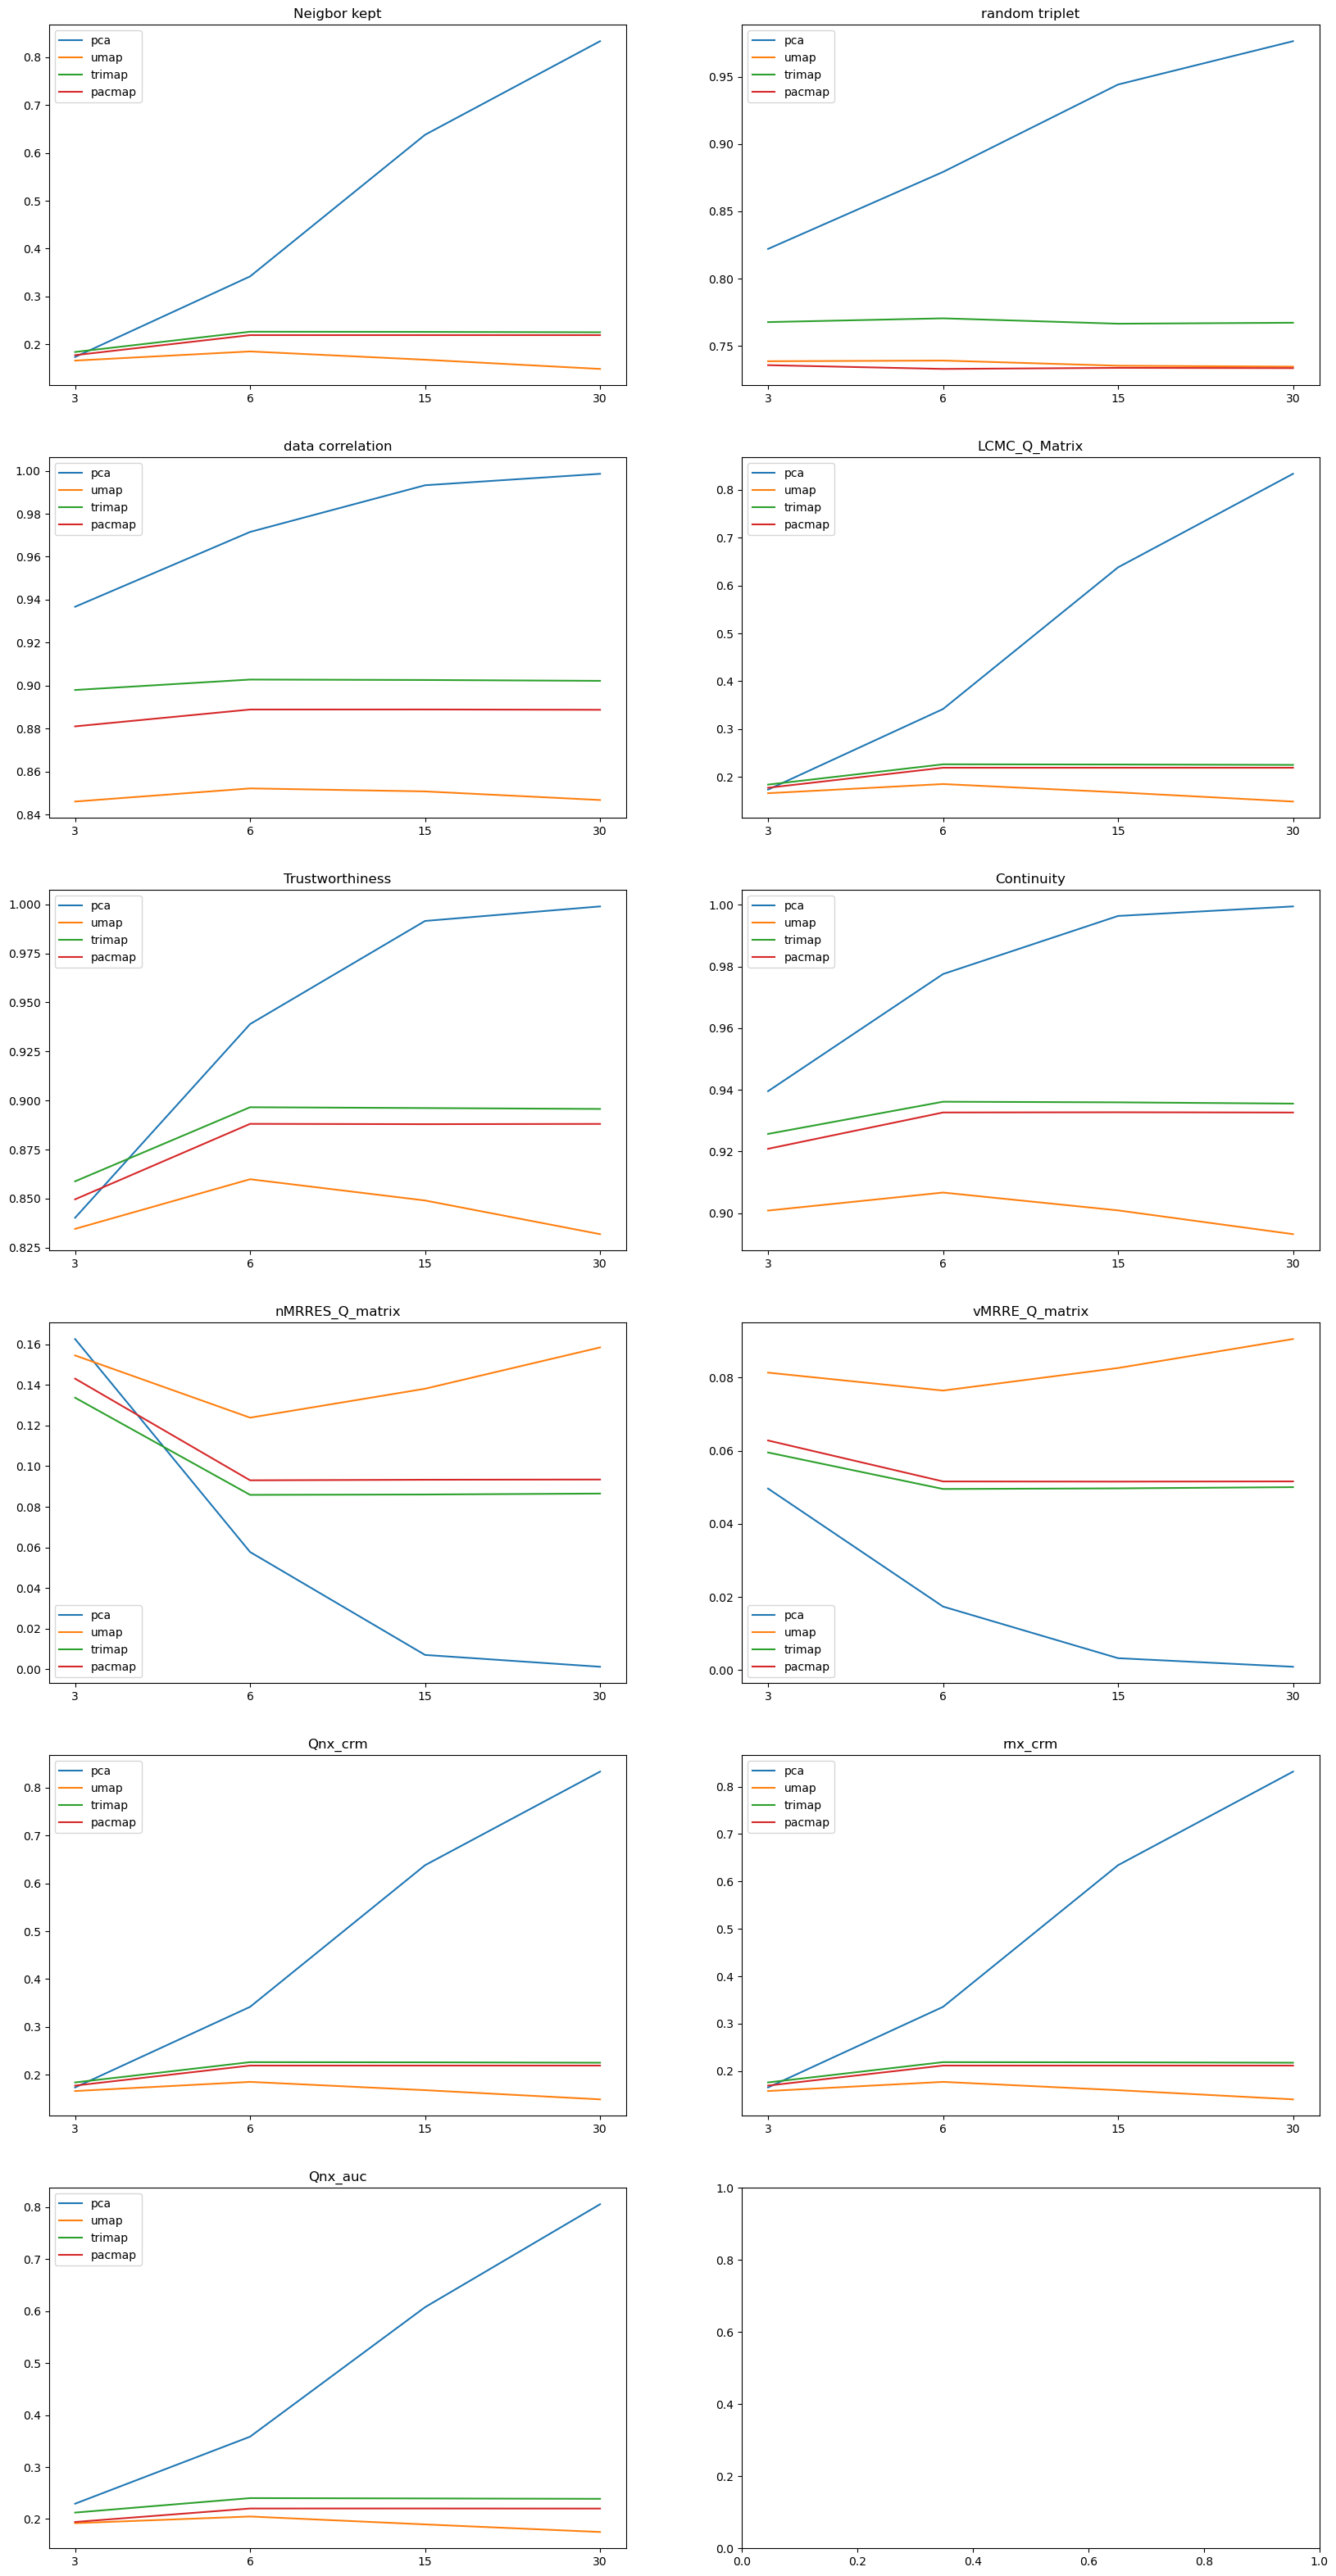

In [14]:
import re

fig, ax = plt.subplots(6,2,figsize = (20,40))

labels = ['pca','umap','trimap','pacmap']

for n,performances in enumerate([performance_dict_pca,performance_dict_umap,performance_dict_trimap,performance_dict_pacmap]):
    perf_to_plot = None
    for key,value in performances.items():
        if perf_to_plot == None:
            perf_to_plot = {k[0]:[] for k in value}
            perf_to_plot.update({'n_dims':[]})
        for metric,score in value:
            perf_to_plot[metric].append(score)
        perf_to_plot['n_dims'].append(re.search(r"\d+",key).group())
        
    i,j = 0,0

    for metric in perf_to_plot.keys():
        if metric != "n_dims":
            ax[j,i].plot(perf_to_plot['n_dims'],perf_to_plot[metric], label = labels[n])
            ax[j,i].legend()
            ax[j,i].set_title(metric)
            j = j+1 if i == 1 else j
            i = 0 if i == 1 else 1
            

## KMeans Clustering 

In [94]:
from sklearn.cluster import BisectingKMeans as BKM
from hdbscan import HDBSCAN

### pca

In [100]:
X = pca_model_6.transform(sampled_cd).astype(np.float32)
# bkm_pca6 = BKM().fit(X=X)
labels_pca = HDBSCAN().fit_predict(X)

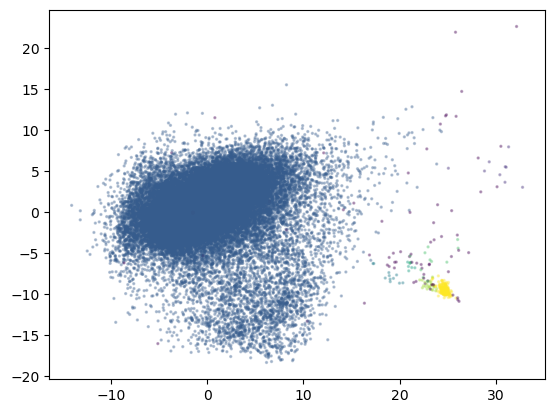

In [101]:
plt.scatter(X[:,0],X[:,1], c= labels_pca, s=2, alpha = 0.3)

### UMAP

In [132]:
X=embedder_6.embedding_
# bkm_umap6 = BKM().fit(X=X)
labels_umap = HDBSCAN().fit_predict(X)

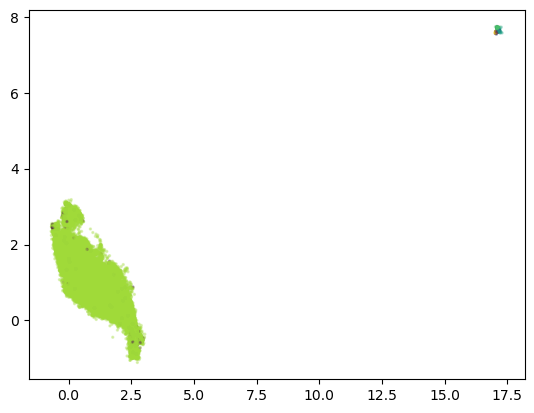

In [133]:
plt.scatter(X[:,0],X[:,1], c= labels_orig, s=2, alpha = 0.3)

### TriMaP


In [130]:
X=trimap_model_6.embedding_
# bkm_trimap6 = BKM().fit(X=X)
labels_trimap = HDBSCAN().fit_predict(X)

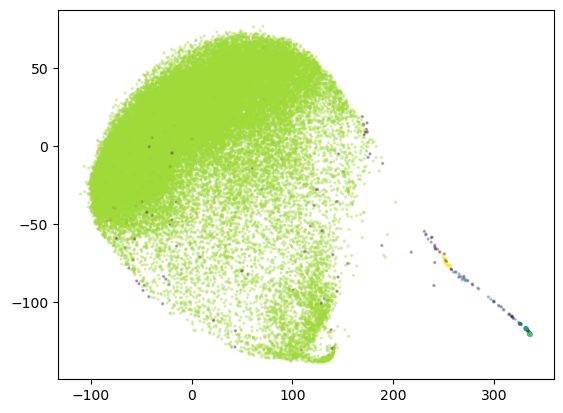

In [131]:
plt.scatter(X[:,0],X[:,1], c= labels_orig, s=2, alpha = 0.3)

### Pacmap

In [106]:
X=pacmap_model_6.embedding_
# bkm_pacmap6 = BKM().fit(X=X)
labels_pacmap = HDBSCAN().fit_predict(X)

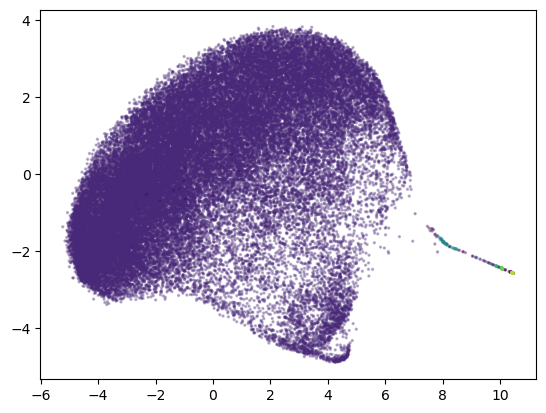

In [107]:
plt.scatter(X[:,0],X[:,1], c= labels_pacmap, s=2, alpha = 0.3)

### SAMMON

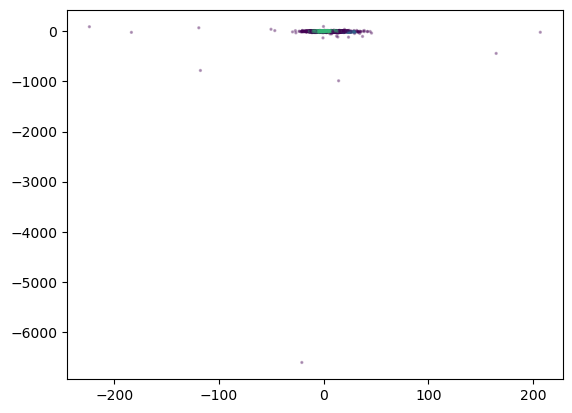

In [127]:
from sklearn.preprocessing import StandardScaler

X=np.transpose(sm.X_transformed)
# bmk_orig = BKM().fit(X=X)
labels_sammon = HDBSCAN().fit_predict(X)

plt.scatter(
    X[:,0],
    X[:,1], 
    c= labels_sammon, 
    s=2, 
    alpha = 0.3)

### original_data

In [146]:
from sklearn.preprocessing import StandardScaler

X=StandardScaler().fit_transform(sampled_cd)

bmk_orig = BKM(bisecting_strategy='biggest_inertia').fit(X=X)
labels_orig = bmk_orig.predict(X)

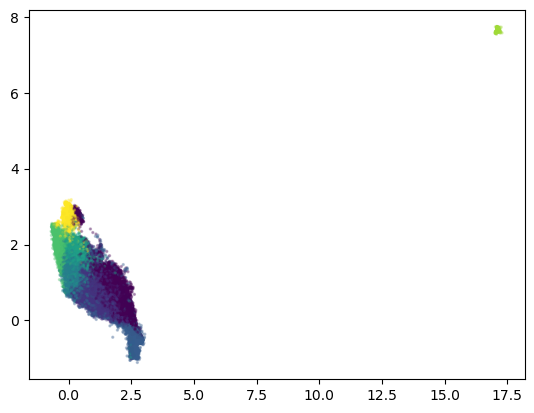

In [149]:
X=embedder_6.embedding_
plt.scatter(
    X[:,0],
    X[:,1], 
    c= labels_orig, 
    s=2, 
    alpha = 0.3)

### check cluster distances

In [147]:
df = pd.DataFrame(sampled_cd,columns = cols_c_b_combo)
df['label'] = labels_orig

In [187]:
metric = 'manhattan'

X_pca = pca_model_6.transform(sampled_cd)
X_umap = embedder_6.embedding_
X_trimap = trimap_model_6.embedding_
X_pacmap = pacmap_model_6.embedding_

cluster_eval_pca = {}
cluster_eval_umap = {}
cluster_eval_trimap = {}
cluster_eval_pacmap = {}

for label in tqdm(df.label.unique()):
    index = df.loc[df.label == label].index
    for n,embedding in enumerate([X_pca,X_umap,X_trimap,X_pacmap]):
        evaluate = qm.CDEmbeddingPerformance(knn_dist='jaccard',n_neighbours=100,dcor_level=1,metric=metric)
        df_clust = df.loc[index].to_numpy(dtype = np.float32)
        emb_clust = embedding[index]
        Qmatrix = evaluate._get_coranking_matrix(
            X_org=df_clust, X_emb=emb_clust, backend="numba"
            )
        
        dat_cor = evaluate._return_distance_correlation(df_clust,emb_clust)
        random_triplet = evaluate.random_triplet_eval(df_clust,emb_clust)

        if n == 0:
            cluster_eval_pca.update({label:[dat_cor,random_triplet]})
        elif n == 1:
            cluster_eval_umap.update({label:[dat_cor,random_triplet]})
        elif n == 2:
            cluster_eval_trimap.update({label:[dat_cor,random_triplet]})
        else:
            cluster_eval_pacmap.update({label:[dat_cor,random_triplet]})
        

100%|██████████| 8/8 [13:55<00:00, 104.43s/it]


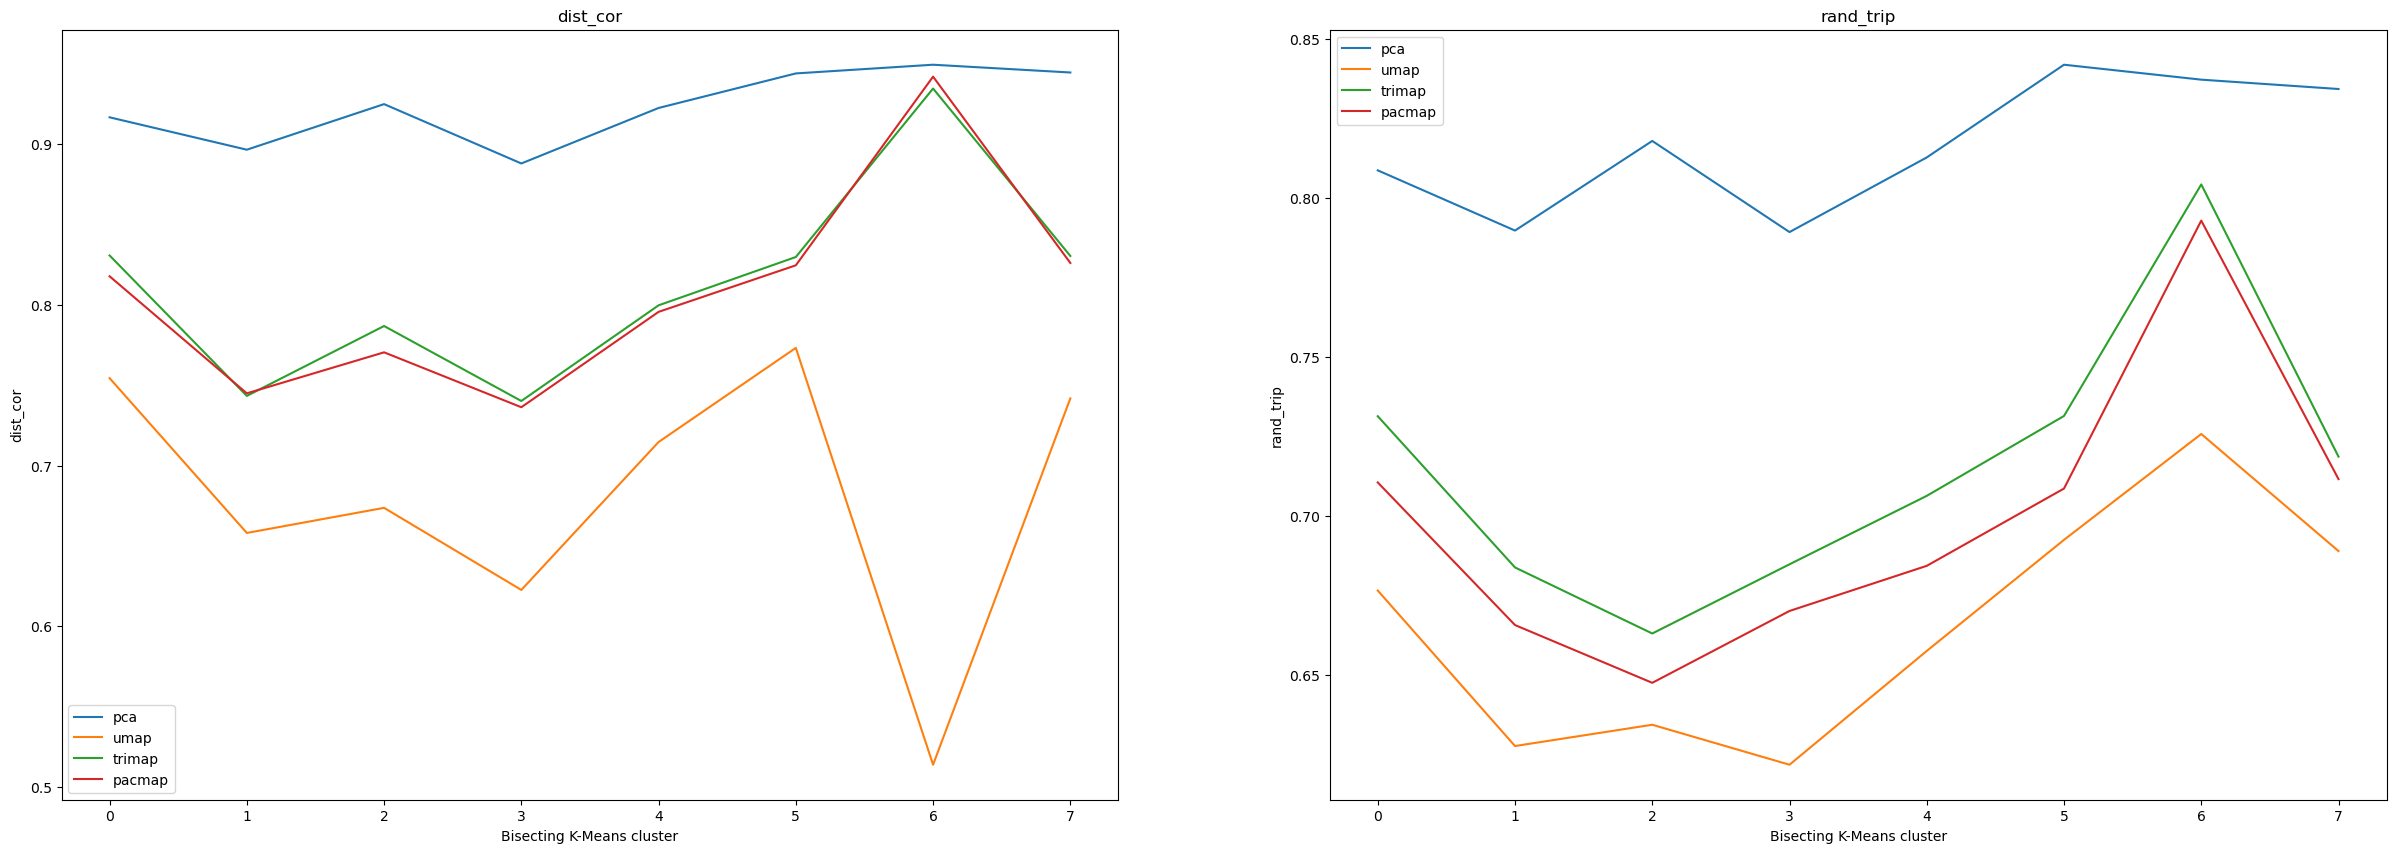

In [193]:

fig,ax = plt.subplots(1,2,figsize = (30,10))
for emb,eval_dict in {k:v for k,v  in zip(['pca','umap','trimap','pacmap'],[cluster_eval_pca,cluster_eval_umap,cluster_eval_trimap,cluster_eval_pacmap])}.items():
    for i,metric in enumerate(['dist_cor','rand_trip']):
        ax[i].plot(sorted(eval_dict),[eval_dict[key][i] for key in sorted(eval_dict)],label = emb)
        ax[i].legend()
        ax[i].set_xlabel("Bisecting K-Means cluster")
        ax[i].set_ylabel(metric)
        ax[i].set_title(metric)

#### KMeans Cluster center preservation

In [218]:
km_centers_pca = pca_model_6.transform(bmk_orig.cluster_centers_)
km_centers_umap = embedder_6.transform(bmk_orig.cluster_centers_)
km_centers_pacmap = pacmap_model_6.transform(bmk_orig.cluster_centers_, sampled_cd)

In [224]:
import dcor

In [227]:
print("pca_dcor",dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_pca))
print("umap_dcor",dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_umap))
print("pacmap_dcor",dcor.distance_correlation(bmk_orig.cluster_centers_,km_centers_pacmap))

pca_dcor 0.9999292259651044
umap_dcor 0.9745124675113953
pacmap_dcor 0.9398988040077206
